In [1]:
%matplotlib inline
%load_ext memory_profiler

import os, sys, glob, re, math, pickle
import phate,scprep,magic,meld
import graphtools as gt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time,random,datetime
from sklearn import metrics
from sklearn import model_selection
from scipy import sparse
from scipy.stats import mannwhitneyu, tiecorrect, rankdata
from statsmodels.stats.multitest import multipletests
import scanpy as sc
import scvelo as scv
from adjustText import adjust_text
import warnings



# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=9)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1
sns.set_style("ticks")

In [2]:
# fps
dfp = '/home/cl2292/project/SCA1_snRNAseq/Human/data/'
pfp = '/home/cl2292/project/SCA1_snRNAseq/Human/results_20230402/'
pdfp = '/home/cl2292/project/SCA1_snRNAseq/Human/data/processed/'
sc.settings.figdir = pfp

In [3]:
def AnnData2df(AnnData,genes,layer='imputed_bbknn',id1='timepoint',id1_val='5wk',id2='ctype',id2_val='Purkinje cell',add_obs='genotype',scaler='range'):
    """Quick grab, select layer.
    
    Args:
      AnnData (object): 
      id1 (string): where in AnnData.obs to pull
      genes (list): list of genes to subset
      scaler (str): if 'range', min-max scaled to 0 and 1 
      
    Returns:
      pd.DataFrame
    """
    if id2 is not None :
        adata = sc.AnnData(AnnData[(AnnData.obs[id1]==id1_val) & (AnnData.obs[id2]==id2_val),:])
        adata = sc.AnnData(adata[:,genes])
    elif id1 is not None :
        adata = sc.AnnData(AnnData[(AnnData.obs[id1]==id1_val),:])
        adata = sc.AnnData(adata[:,genes])
    else : # both id1/id2 not given
        adata = sc.AnnData(adata[:,genes])

    if layer is not None:
        x = adata.layers[layer]
    else:
        x = adata.X
                
    if scaler is not None :
        x = (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0))
    X = pd.DataFrame(x,columns=adata.var_names,index=adata.obs.index)
        
    if add_obs is not None :
        X[add_obs]=adata.obs[add_obs]
        
    return X

In [4]:
# Load Data

if True :
    start = time.time()
    backed=None # None if not
    fname='230502_Ctrl_sampling_AS BG OPC OL MG PER END.h5ad' # for full, can maybe get away with ~300G
    %memit wt = sc.read_h5ad(os.path.join(pdfp,fname),backed=backed)
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))
    
# Load Data

if True :
    start = time.time()
    backed=None # None if not
    fname='230502_SCA1_sampling_AS BG OPC OL MG PER END.h5ad' # for full, can maybe get away with ~300G
    %memit mut = sc.read_h5ad(os.path.join(pdfp,fname),backed=backed)
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))

peak memory: 2839.67 MiB, increment: 2638.34 MiB
loaded @230512.11:56:48
took 5.36-s to load data
peak memory: 6986.10 MiB, increment: 4146.39 MiB
loaded @230512.11:56:52
took 4.50-s to load data


In [5]:
# aesthetics 
cmap_genotype={'Ctrl':'#010101',
               'SCA1':'#ffd478'}

In [6]:
genes_TF = {'TF':[
        'ASCL1',
        'HES1',
        'ID2',
        'ID4',
        'MYT1',
        'NKX2-2',
        'OLIG1',
        'OLIG2',
        'TCF7L2',
        'SOX9',
        'SOX10',
        'NKX6-2',
        'SOX17',
        'ZNF24',
        'ZNF488',
        'ZNF536',
        'MYRF']}

In [7]:
# human
cluster='sub4'
ctype='OL'
layer = 'imputed'
adata = wt
        
df = pd.DataFrame()

#Ctrl
adata = adata[(adata.obs[cluster]==ctype),:]
x = adata.layers[layer]
# x = (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0))
X = pd.DataFrame(x,columns=adata.var_names,index=adata.obs.index)
X['genotype']=adata.obs['genotype']
X = pd.melt(X, id_vars='genotype',value_name='Expression',var_name='Gene')
df = df.append(X, ignore_index=True)
del X

#SCA1
adata = mut

adata = adata[(adata.obs[cluster]==ctype),:]
x = adata.layers[layer]
# x = (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0))
X = pd.DataFrame(x,columns=adata.var_names,index=adata.obs.index)
X['genotype']=adata.obs['genotype']
X = pd.melt(X, id_vars='genotype',value_name='Expression',var_name='Gene')
df = df.append(X, ignore_index=True)
del X


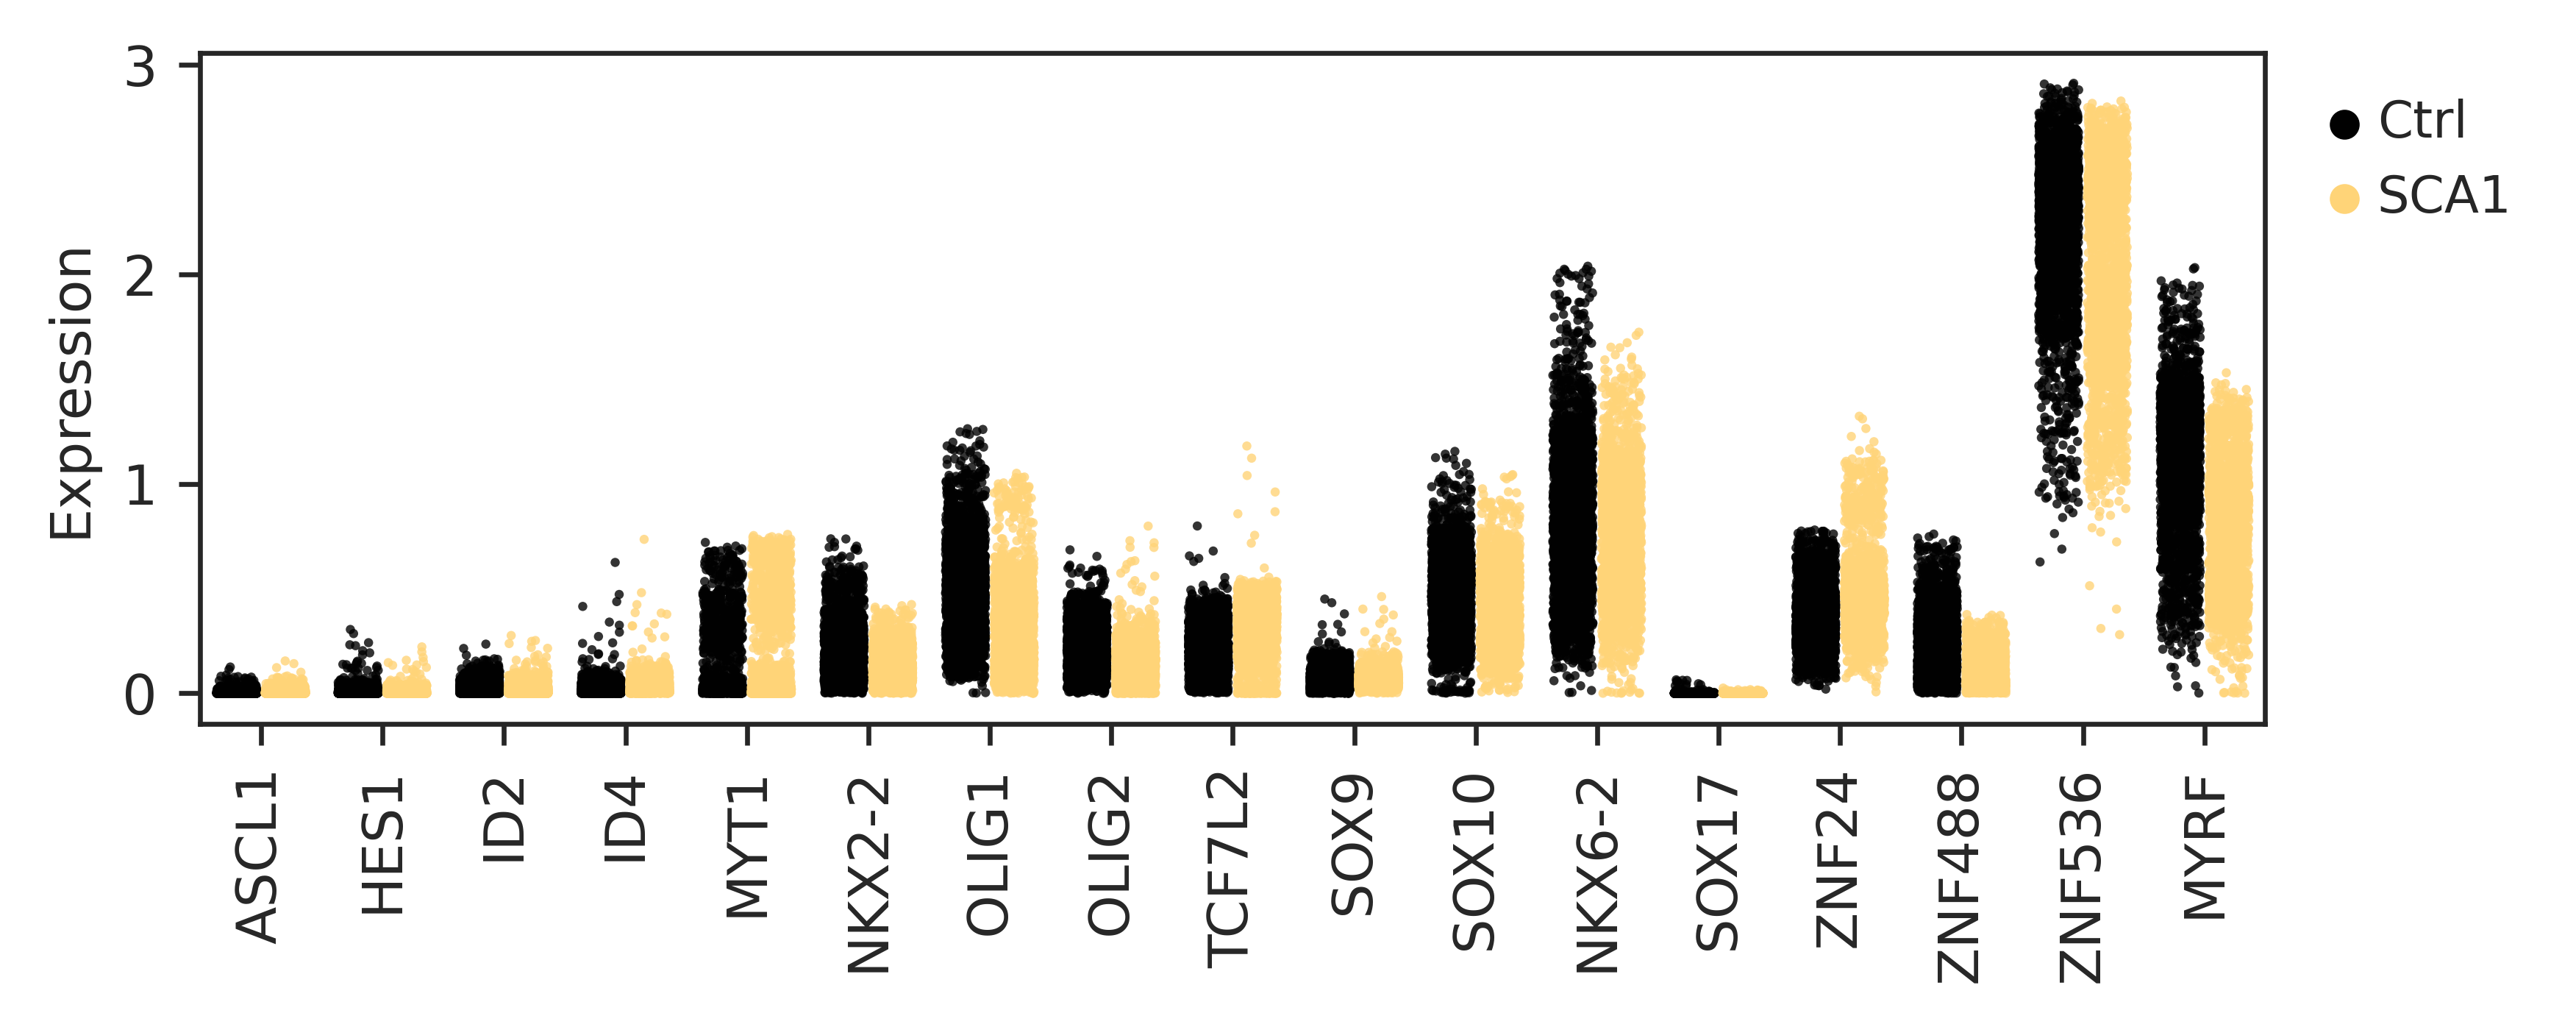

In [8]:

for k in genes_TF.keys():
    df_subset = df.loc[df['Gene'].isin(genes_TF[k]),:]
    
    fig,ax=plt.subplots(1,1,figsize=(6,2))
    p1 = sns.stripplot(x='Gene', y='Expression', hue='genotype', data=df_subset, order=[
        'ASCL1',
        'HES1',
        'ID2',
        'ID4',
        'MYT1',
        'NKX2-2',
        'OLIG1',
        'OLIG2',
        'TCF7L2',
        'SOX9',
        'SOX10',
        'NKX6-2',
        'SOX17',
        'ZNF24',
        'ZNF488',
        'ZNF536',
        'MYRF'], hue_order=['Ctrl','SCA1'], jitter=0.33, dodge=True, 
                      orient=None, color=None, palette=cmap_genotype, size=0.5, alpha=0.8, edgecolor='gray', linewidth=0,ax=ax,
                      rasterized=True, s=1.5)
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.legend().set_title('')
    ax.legend(bbox_to_anchor=(1.01,1))
    if True :
        # save plot
        fig.savefig(os.path.join(pfp,'230512_jitter_{}_OL_TF.pdf'.format(k)),dpi=300, bbox_inches='tight')
        

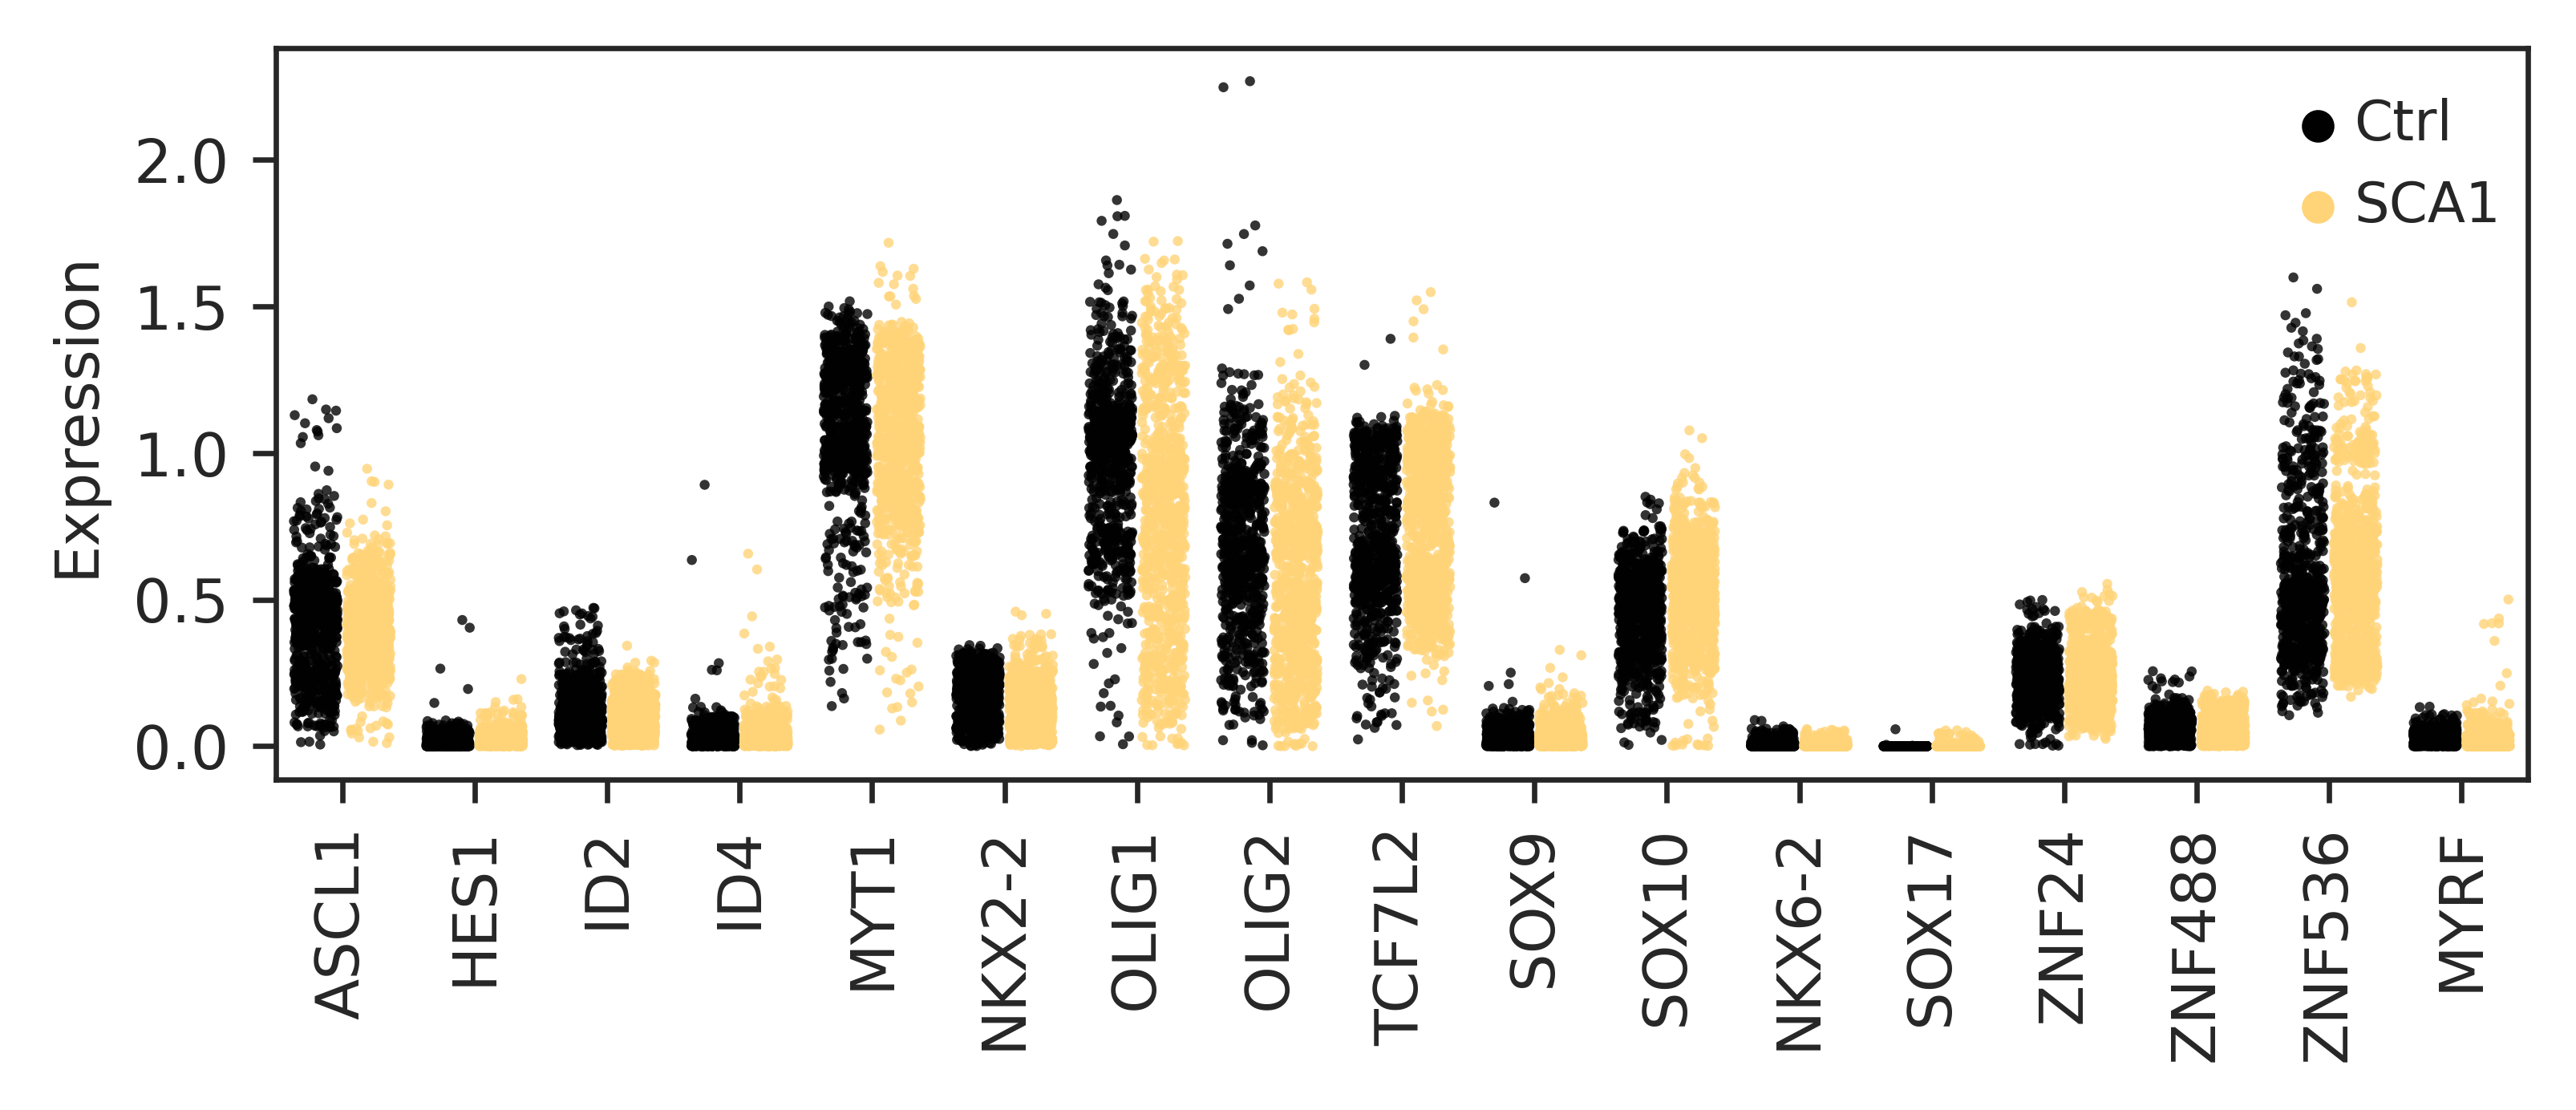

In [9]:
# human OPC
cluster='sub4'
ctype='OPC'
layer = 'imputed'
adata = wt
        
df = pd.DataFrame()

#Ctrl
adata = adata[(adata.obs[cluster]==ctype),:]
x = adata.layers[layer]
# x = (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0))
X = pd.DataFrame(x,columns=adata.var_names,index=adata.obs.index)
X['genotype']=adata.obs['genotype']
X = pd.melt(X, id_vars='genotype',value_name='Expression',var_name='Gene')
df = df.append(X, ignore_index=True)
del X

#SCA1
adata = mut

adata = adata[(adata.obs[cluster]==ctype),:]
x = adata.layers[layer]
# x = (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0))
X = pd.DataFrame(x,columns=adata.var_names,index=adata.obs.index)
X['genotype']=adata.obs['genotype']
X = pd.melt(X, id_vars='genotype',value_name='Expression',var_name='Gene')
df = df.append(X, ignore_index=True)
del X


for k in genes_TF.keys():
    df_subset = df.loc[df['Gene'].isin(genes_TF[k]),:]
    
    fig,ax=plt.subplots(1,1,figsize=(6,2))
    p1 = sns.stripplot(x='Gene', y='Expression', hue='genotype', data=df_subset, order=[
        'ASCL1',
        'HES1',
        'ID2',
        'ID4',
        'MYT1',
        'NKX2-2',
        'OLIG1',
        'OLIG2',
        'TCF7L2',
        'SOX9',
        'SOX10',
        'NKX6-2',
        'SOX17',
        'ZNF24',
        'ZNF488',
        'ZNF536',
        'MYRF'], hue_order=['Ctrl','SCA1'], jitter=0.33, dodge=True, 
                      orient=None, color=None, palette=cmap_genotype, size=0.5, alpha=0.8, edgecolor='gray', linewidth=0,ax=ax,
                      rasterized=True, s=1.5)
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.legend().set_title('')
    ax.legend(bbox_to_anchor=(1.01,1))
    if True :
        # save plot
        fig.savefig(os.path.join(pfp,'230512_jitter_{}_OPC_TF.pdf'.format(k)),dpi=300, bbox_inches='tight')
        
